# Input and State Estimation by Convex Optimization
*Created: M.M., 12.1.2023*

*Updated: M.M. 7.3.2023*

## Discrete-time linear time-invarient (LTI) systems

Consider a contineous-time LTI system

\begin{align}
\dot{x}(t) &= A_{\mathrm{c}}x(t) + B_{\mathrm{c}}u(t)\\
y(t) &= Cx(t).
\end{align}

If measurements $y$ are obtained with a constant sampling time $T_\mathrm{s}$ at time instances $t \in \{kT_\mathrm{s}$: $k=0,1,2,...\}$, assuming that $u$ is constant inbetween samples, a discrete-time samples state space representation is of the form (cf. [wiki.](https://en.wikipedia.org/wiki/Discretization#Derivation))

$$
\begin{align}
    x(k+1) &= Ax(k) + Bu(k),\\
    y(k) &= Cx(k),
\end{align}
$$

where, $u$ is an input vector, and

$$
\begin{align}
A &= \mathrm{e}^{A_\mathrm{c}T_\mathrm{s}}\\
B &= A_\mathrm{c}^{-1}( A - I )B
\end{align}
$$

If $u$ is is unknown input (disturbance), the goal of the estimation is to reconstructed from $N$ measurements $y(0), y(1), .., y(N-1)$.

### Impulse response
The impulse response is is obtained by passing an input signal $u(0)=1$ and $u(k)=0$ for $k\neq 0$ through the system. For initial state $x(0)=0$, yhe impulse response is

\begin{align}
    y_\delta(0) &= 0\\
    y_\delta(1) &= Cx(1) = C(Ax(0) + B) = CB\\
    y_\delta(2) &= Cx(2) = C( Ax(1) ) = C( A( Ax(0) + B ) ) = CAB\\
    &\vdots \\
    y_\delta(n) &= CA^{n-1}B, n>0. 
\end{align}


### The data equation
Repeated substitution of $x(k)$ into $y(k)=Cx(k)$ gives

$$
\begin{aligned}
    y(0) &= Cx(0),\\
    y(1) &= CAx(0) + Bu(0),\\
    \vdots &\\
    y(n) &= CA^{n}x(0) + \sum_{k=0}^{n-1} CA^{k}u(n-k-1),\\
    \vdots &
\end{aligned}
$$

or in matrix form

$$
\underbrace{
\begin{bmatrix}
y(0)\\
y(1)\\
y(2)\\
\vdots\\
y(N-1)
\end{bmatrix}
}_{y}
=
\underbrace{
\begin{bmatrix}
C\\
CA\\
CA^2\\
\vdots\\
CA^{N-1}
\end{bmatrix}
}_{\mathcal{O}}
x(0)
+
\underbrace{
\begin{bmatrix}
0 &0 &\cdots &0\\
CB &0 &\cdots &0\\
CAB &CB &\cdots &0\\
\vdots &\vdots &\ddots &\vdots\\
CA^{N-2}B &CA^{N-3}B &\cdots &0
\end{bmatrix}
}_{\Gamma}
\underbrace{
\begin{bmatrix}
u(0)\\u(1)\\u(2)\\ \vdots\\ u(N-1)
\end{bmatrix}
}_{u}.
$$

The section on *subspace system identification* in the book [Filtering and System Identification](https://books.google.fi/books?hl=sv&lr=&id=6Ne76uYOlVwC&oi=fnd&pg=PR11&dq=verhaegen+least+squares+approach&ots=H7GzIs_Rab&sig=PfKVrPuYiSlWfjI3_tymLiI1-U8&redir_esc=y#v=onepage&q=verhaegen%20least%20squares%20approach&f=false) by Verhaegen, Michel, and Vincent Verdult explains this well (*read*: check that I havent done any mistakes here).

* **Note**: This equation is commonly occuring in the control-theory and system identification litterature and is often referred to as the *data equation*. Here I have used the standard notation $\mathcal{O}$ for the extended observability matrix (which is used for determining stability of a system), and $\Gamma$ for the impulse response matrix. The impulse response of the system is $h(k) = CA^{k-1}B$. In [(Ikonen et al.,2015)](https://www.sciencedirect.com/science/article/pii/S0165232X14002274), the non-standard notation  $g(k)=h(k)$, $R=y$, $G = \Gamma$, and $M = u$ was used instead.


### Example: Mass-spring-damper system

In [206]:
import numpy as np
from scipy.linalg import expm
from numpy.linalg import matrix_power
from scipy import signal
import matplotlib.pyplot as plt

In [145]:
# Consider the mass-spring-damper system of the form
# dx/dt = Ax + B_1u-1 + B_2u_2
# where u_1 is a known input signal, and u_2 is unknown.

# spring, damper, mass parameters
I_1 = .1    #inertia [kgm^2]
I_2 = .5
k = 1    #stiffness [Nm/rad]
c = .2  #damping [Nm/(rad/s)]

#contineous-time state space
A_c = np.matrix([[-c/I_1, c/I_1, -k/I_1],[c/I_2, -c/I_2, k/I_2],[1, -1, 0]])
B_c = np.matrix([[1/I_1, 0],[0, 1/I_2],[0, 0]])

print(A_c)
print(B_c)

[[ -2.    2.  -10. ]
 [  0.4  -0.4   2. ]
 [  1.   -1.    0. ]]
[[10.  0.]
 [ 0.  2.]
 [ 0.  0.]]


#### Discrete-time system

In [241]:
def c2d(A_c,B_c,T_s):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time T_s.
    The function returns matrices A,B of the discrete-time system.
    """
    m,n = A_c.shape
    m,nb = B_c.shape

    s = np.concatenate([A_c,B_c], axis=1)
    s = np.concatenate( [s, np.zeros( (nb,n+nb) )],axis=0 )
    S = expm(s*T_s)
    A = S[0:n,0:n]
    B = S[0:n,n:n+nb+1]
    return A, B

#sampling time
T_s = 0.1

#discrete-time system
A, B = c2d(A_c,B_c,T_s)    


#### Impulseresponse if systems

Text(0.5, 1.0, 'Impulse response u_2 to y')

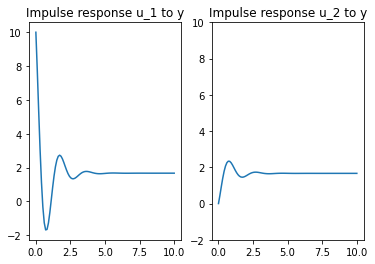

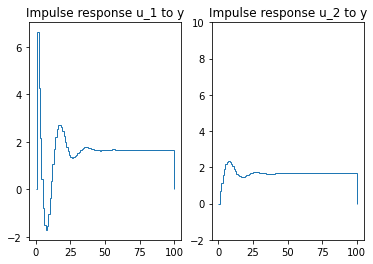

In [249]:
def impulsec(A,B,C,time):
    """
    IMPULSEC returns the impulse response h of a contineous-time state-space system (A,B,C).
    """
    N = time.shape[0]
    m,nb = B.shape
    h = np.zeros((N,nb))
    for i,t in enumerate(time):
       h[i,:] = C@expm(A*t)@B
    return h

def impulsed(A,B,C,T_s,N):
    """
    IMPULSED returns the impulse response h of a discrete-time state-space system (A,B,C).
    """
    r,n = C.shape
    n,nb = B.shape
    h = np.zeros((N,nb))
    for i in range(N):
        if i==0:
            h[i,:] = np.zeros((r,nb))
        else:
            h[i,:] = C@matrix_power(A,i)@B/T_s    
    return h


N = 100
Nd = int(t_max/T_s)
t_max = 10
time = np.linspace(0, t_max, num=N)
C = np.array([[1, 0, 0]])


#impulse response
h_c = impulsec(A_c,B_c,C,time)
h_d = impulsed(A,B,C,T_s,Nd)


#plot impulse response
fig, axs = plt.subplots(1, 2)
plt.ylim([-2, 10])
axs[0].plot(time,h_c[:,0])
axs[1].plot(time,h_c[:,1])

axs[0].set_title("Impulse response u_1 to y")
axs[1].set_title("Impulse response u_2 to y")

#plot impulse response
fig, axs = plt.subplots(1, 2)
plt.ylim([-2, 10])
axs[0].stairs(h_d[:,0])
axs[1].stairs(h_d[:,1])

axs[0].set_title("Impulse response u_1 to y")
axs[1].set_title("Impulse response u_2 to y")

## Non-uniformly sampled LTI systems
M.M. 6.3.2023 - Draft: Not proofread!

In practice, systems are often not sampeled with a constant sampling rate. This is especially true for rotating machinery. It is not uncommon that angular velocities, and twist are measured a fixed number of times per revolution. Thus, as the angular velocity changes, the sampling rate is not constant. However, unlike for a Kalman filter which in it's standard form requires a fixed sampling rate, non-uniform sampling rates can quite easily be incorporated in the proposed convex optimization-based estimation framework.

Consider a contineous-time LTI system sampeled at time instances $t = t_0, t_1,..., t_n$

\begin{align}
\dot{x}(t) &= Ax(t) + Bu(t)\\
y(t_k) &= Cx(t_k).
\end{align}

To solve the differential equaiton first recall that (cf. [wiki.](https://en.wikipedia.org/wiki/Discretization#Derivation))

\begin{equation}
\frac{\mathrm{d}}{\mathrm{d}t}\left( \mathrm{e}^{-At}x(t) \right) = \mathrm{e}^{-At}\left(\dot{x}(t) - Ax(t)\right)
\end{equation}

(by the product rule). Pre-multiplying the state-equation with $\mathrm{e}^{-At}$ and rearranging the terms gives

\begin{equation}
    \mathrm{e}^{-At}\left( \dot{x}(t) - Ax(t) \right) = \mathrm{e}^{-At}Bu(t)
\end{equation}

or  equivalently

\begin{equation}
    \frac{\mathrm{d}}{\mathrm{d}t}\left( \mathrm{e}^{-At}x(t) \right) = \mathrm{e}^{-At}Bu(t).
\end{equation}

Integrating the above expression from $t_k$ to $t_{k+1}$ gives

\begin{equation}
    \mathrm{e}^{-At_{k+1}}x(t_{k+1}) -  \mathrm{e}^{-At_{k}}x(t_{k}) = \int_{t_k}^{t_{k+1}}\mathrm{e}^{-At}Bu(t) \mathrm{d}t
\end{equation}

and multiply by $\mathrm{e}^{At_{k+1}}$ yields

\begin{equation}
    x(t_{k+1}) =  \mathrm{e}^{A(t_{k+1} - t_{k})}x(t_{k}) + \int_{t_k}^{t_{k+1}}\mathrm{e}^{A(t_{k+1} - t)}Bu(t) \mathrm{d}t.
\end{equation}

By assuming that the input is constant inbetween samples (cf. [wiki.](https://en.wikipedia.org/wiki/Discretization#Derivation)), an exact solution to the differential equtions is obtained

\begin{align}
    x(t_{k+1}) &=  \mathrm{e}^{A(t_{k+1} - t_{k})}x(t_{k}) + \int_{t_k}^{t_{k+1}}\mathrm{e}^{A(t_{k+1} - t)}\mathrm{d}t Bu(t_k)\\
               &=  \mathrm{e}^{A(t_{k+1} - t_{k})}x(t_{k}) + \int_{0}^{t_{k+1}-t_k}\mathrm{e}^{A\tau}\mathrm{d}\tau Bu(t_k)\\
               &=  \mathrm{e}^{A(t_{k+1} - t_{k})}x(t_{k}) + A^{-1}\mathrm{e}^{A\tau}\Big|_0^{t_{k+1}-t_k} Bu(t_k)\\
               &=  \mathrm{e}^{A(t_{k+1} - t_{k})}x(t_{k}) + \left( A^{-1}\mathrm{e}^{A(t_{k+1}-t_k)} - A^{-1} \right) Bu(t_k)\\
               &=  \mathrm{e}^{A(t_{k+1} - t_{k})}x(t_{k}) + A^{-1}\left( \mathrm{e}^{A(t_{k+1} - t_k)} - I  \right)Bu(t_k).
\end{align}

The solution is of the form of a time-varying state-space model
\begin{align}
x(t_{k+1}) &= A_{k}x(t_k) + B_{k}u(t_k),\\
y(t_k) &= Cx(t_k)
\end{align}

with system matrices defined as

\begin{align}
A_{k} &= \mathrm{e}^{A(t_{k+1} - t_{k})}x(t_{k}),\\
B_{k} &= A^{-1}( A_k - I  )B,
\end{align}


### Impulse response
Analogous to the derivation in previous section, we have that, given $x(0)$, the state at time-point $t$ is given by

\begin{equation}
    x(t) = \mathrm{e}^{At}x(0) + \int_{0}^t \mathrm{e}^{A\tau}Bu(\tau)\mathrm{d}\tau,
\end{equation}

and the impulse response is obtained by passing the input signal $u(t)=\delta(\tau)$, where $\delta$ is the Dirac's delta function (see e.g. [wiki.](https://en.wikipedia.org/wiki/Dirac_delta_function). For $x(0) = 0$. We have

\begin{align}
x(t) &= \mathrm{e}^{At}x(0) \int_{0}^t \mathrm{e}^{A\tau}B\delta(\tau)\mathrm{d}\tau = \mathrm{e}^{At}B,
\end{align}

and the impulse response is

\begin{equation}
y_\delta(t) = C\mathrm{e}^{At}B.
\end{equation}

Equivalently, from the results in previous section, the impulse response at time instances $t_0, t_1, ..., t_n$ is

\begin{align}
    y_\delta(t_0) &= 0,\\
    y_\delta(t_k) &= C\mathrm{e}^{At_k}B = C\left(\prod_{n=1}^{k-1} A_n\right)B_0, ~k>0
\end{align}

<span style="color:red">Verify this numerically, indices might be wrong! I would expect $B_0 = B$</span>

### The data equation
The data equation is formed analogously to in the previous section and is given by

\begin{equation}
\begin{bmatrix}
y(t_0)\\
y(t_1)\\
y(t_2)\\
y(t_3)\\
\vdots\\
\end{bmatrix} =
\begin{bmatrix}
C\\
CA_0\\
CA_1A_0\\
CA_2A_1A_0\\
\vdots
\end{bmatrix}x(t_0)
+
\begin{bmatrix}
0          &0          &0          &\cdots\\
CB_0       &0          &0          &\cdots\\
CA_1B_0    &CB_1       &0          &\cdots\\
CA_2A_1B_0 &CA_2B_1    &CB_2       &\cdots\\
\vdots     &\vdots     &\vdots     &\ddots
\end{bmatrix}
\begin{bmatrix}
u(t_0)\\
u(t_1)\\
u(t_2)\\
u(t_3)\\
\vdots
\end{bmatrix}.
\end{equation}

Alternatively, the system can be expressed using matrix exponentials by noting that 

$$
A_{n-1} \cdots A_2A_1A_0 = \prod_{k=0}^{n-1} A_k = \mathrm{e}^{A(t_{1}-t_0)}\mathrm{e}^{A(t_{2}-t_1)}\mathrm{e}^{A(t_{3}-t_2)} \cdots \mathrm{e}^{A(t_{n}-t_{n-1})} = \mathrm{e}^{A(t_{n}-t_0)}.
$$

**Note** If the assumption that the input is constant in between samples is to restrictive, some other interpolation model can be applied, e.g. (maybe) the trapetzoidal rule could work.

### Example: Mass-spring-damper system

## Input Estimation by Convex Optimization
In the following paper, the input-estimation problem was posed as an regularized inverse problem.

* Ikonen T., Peltokorpi, O. & Karhunen J. (2015),[Inverse ice-induced moment determination on the propeller of an ice-going vessel](https://www.sciencedirect.com/science/article/pii/S0165232X14002274). Cold Regions Science and Technology, 112, 1-13.

A more straight-forward derivation of the results presented in the paper is obtained by starting from a state-space representation of the system (see e.g. [Manngård et al., (2018)](https://www.sciencedirect.com/science/article/pii/S0888327022001480), [Manngård et al., (2022)](https://www.sciencedirect.com/science/article/pii/S2405896319321822) on how to represent drivetrains in a state-apace form).

### Tikhonov regularization
Since $y,\mathcal{O},$ and $\Gamma$ are known, we can, for example, estimate $u$ by solving a Tikhonov-regularized quadratic optimization problem:

$$
\underset{u, x(0)}{\mathrm{min}} || y - \mathcal{O}x(0) - \Gamma u ||^2_2 + \lambda|| Lu ||^2_2,
$$

where $\lambda$ is a regularization parameter and $L$ is a regularization matrix (to be determined by the used). The purpose of the matrix $L$ is to enforce additional constraints of the solution, such as smoothness. For $x(0)=0$ the Tikhonov regularized optimization problem has the solution is

$$
\hat{u} = \left(  \Gamma^\top \Gamma + L^\top L  \right)^{-1} \Gamma^\top y.
$$

* **Note** that we have treated the initial state $x(0)$ as unknown and to be estimated (as is the case in most applications). However, if we set $x(0)=0$, the same solution as in Eq. 33 in the paper by [Ikonen et al.,(2015)](https://www.sciencedirect.com/science/article/pii/S0165232X14002274) is obtained.

The difference between this approach, and Kalman filtering is that the Kalman filter produces  optimal estimates of the state $x(n)$ and inputs (disturbances) $u(n)$ based on the observations $y(0),...,y(n)$ observed up until time-instance $n$, whereas the optimization method used all available measurements $\{y(0),y(1),...,y(n),... y(N)\}$ as a batch. Thus, the optimization approach is expected to perform better than the Kalman filter. However, the effect that the regularization has on the results may be hard to analyze, and solving the optimization problem in real-time myght be a challenge. Especially if the sampling rate is high.

### Example: Input reconstruction using Tikhonov regularization

### Trend filtering and sparse optimization
Instead of using Tikhonov regularization, $\ell_1$ regularization can be used instead to enforse sparsity of the solution. The $\ell_1$ regularization results in a convex optimization problem 

$$
\underset{u\in\mathbb{R}^N, x(0)}{\mathrm{min}} || y - \mathcal{O}x(0) - \Gamma u ||^2_2 + \lambda|| Lu ||_1 .
$$

Although there exists no explicit solutions to this type of optimization problems, moderately sized problems can be solved efficiently using numerical convex optimization. A good python package for convex optimization is [CVXPY](https://www.cvxpy.org/).

Examples of how $L$ can be determined to enforce structure in a solution, e.g., sparsity of piece-wise linearity, step-wise changes etc., see [Kim, Seung-Jean, et al, (2009)](https://epubs.siam.org/doi/abs/10.1137/070690274), [Shirdel et al. (2016)](https://www.sciencedirect.com/science/article/pii/S0959152416300531), and [Manngård et al. (2017)](https://www.sciencedirect.com/science/article/pii/B9780444639653500532). An interesting research problem would be on how to determine $L$ to best represent common disturbances acting on propulsion-system drivetrains.

### Sparse signals in the frequency domain
In sparse optimization a common assumption is that signals have a sparse Fourier-series representation. In that case, $u$ would be expanded in terms of the Fourier-series coefficients

$$
u(n) = \frac{1}{N}\sum_{k=0}^{N-1} U_k \mathrm{e}^{\mathrm{i}2\pi kn/N},
$$
and $u = FU$, where the elements of the matrix $F$ are determined by the basis functions coefficients $F_{n,k} = \mathrm{e}^{\mathrm{i}2\pi kn/N}$. The assumption that $u$ only contains a few frequency components (such as harmonic frequencies), i.e. $U$ is sparse, can be enforced by solving the following $\ell_1$-regularized sparse-optimization problem

$$
\underset{U\in\mathbb{C}^N, x(0)}{\mathrm{min}} || y - \mathcal{O}x(0) - \Gamma FU ||^2_2 + \lambda|| U ||_1.
$$

Note that the unknowns $U_k$ here are complex-valued. Although this increases the complexity of the problem, most convex optimization solvers have no problems handeling complex variables.

### Example: Input reconstruction using sparse optimization